## Test 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/libs/")

import tensorflow_datasets as tfds

from IPython import display 

import numpy as np 

import pandas as pd 

import tensorflow as tf 

import data_augmentation 

import data_generator
 
import matplotlib.pyplot as plt
# from lr_finder import LRFinder
import data_processing
import get_models
import predict
# from data_generator import Da
from math import ceil


import keras
import tensorflow as tf
from keras import layers, Input
from keras.utils import np_utils 

from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation,Average
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, ResNet50V2, MobileNetV2, MobileNetV2
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import load_model, Model
from tensorflow.keras import regularizers
from sklearn import model_selection

from sklearn.utils import shuffle
import attention_module

In [ ]:
emotionferp = ["Neutral" , "Happiness", "Surprise", "Sadness", "Anger", "Disgust" , "Fear"  ]
emotionfer = ["Angry" , "Disgust", "Fear", "Happy", "Sad", "Surprise" , "Neutral"  ]

### FerPLus

In [ ]:
X , y = data_processing.get_ferpus()
X, y = data_processing.ferplus_processing(X,y)
y_new = data_processing.majority_vote(y)

# Split Data Train and Test
X_train, y_train, X_test, y_test = data_processing.split_data(X, y_new)

In [ ]:
# Offline augmentation
X_train, y_train, X_val, y_val= data_processing.split_data(X_train,y_train)

X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 6, number_aug =3)

#Split Data Train and Val

X_train, y_train = shuffle(X_train, y_train)



In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(32257, 48, 48, 1)
(3194, 48, 48, 1)
(3549, 48, 48, 1)


### Fer2013

In [ ]:
# Get data
emotion = ["Angry" , "Disgust", "Fear", "Happy", "Sad", "Surprise" , "Neutral"  ]
PATH_FER = "/content/drive/MyDrive/WorkSpace/AI_Research/datasets/Fer/icml_face_data.csv"
data = pd.read_csv(PATH_FER)
X, y = data_processing.get_fer(data)
X = np.array(X)
X = X.reshape((X.shape[0], 48, 48, 1))
X_train,y_train, X_test, y_test, X_val, y_val = data_processing.load_fer(data)
# Offline augmentation
datagen_val = data_augmentation.val_augmentation(X_val)


X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 1, number_aug = 7)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug =1)

X_train, y_train = shuffle(X_train, y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34932, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


## RaF DB

In [ ]:
X_train = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_images.npy")
y_train = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_labels.npy")
# X_test = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_images1.npy")
# y_test = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_labels.npy")
emotionsraf = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger","Neutral"]

In [ ]:
# Offline augmentation
X_train, y_train, X_test, y_test= data_processing.split_data(X_train,y_train)
X_train, y_train, X_val, y_val= data_processing.split_data(X_train,y_train)
# X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 1, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 2, number_aug = 3)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 3)
#Split Data Train and Val

X_train, y_train = shuffle(X_train, y_train)

##VGGface

In [ ]:
train_ds = data_generator.DataGenerator(X_train, y_train, shape = (224,224), n_channel= 1,n_classes = 7, shuffle = True, augmentation = True).to_dataset(data_type = "train")
val_ds = data_generator.DataGenerator(X_val, y_val, shape = (224,224), n_channel = 1,n_classes = 7, augmentation= None).to_dataset(data_type = "val")
test_ds = data_generator.DataGenerator(X_test, y_test, shape = (224,224), n_channel = 1,n_classes = 7, augmentation= None).to_dataset(data_type = "val", batch_size = 1)

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git -q
# Release Version
!pip install keras_vggface - q

ERROR: Invalid requirement: '-'


In [ ]:
!pip install Keras-Applications -q
from keras.utils.layer_utils import get_source_inputs
# check version of keras_vggface
import keras_vggface
# print version
print(keras_vggface.__version__)

0.6


In [ ]:
# Create input shape
img_size_target = 224
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='resnet50', include_top=False, input_shape=None, pooling="max", input_tensor= img_conc)

In [ ]:
vggface.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 224, 224, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['concatenate[0][0

In [ ]:
inputs = vggface.input
output = vggface.output

fcHead = layers.Dense(1024,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5))(output)
fcHead = layers.Activation('relu')(fcHead)
fcHead = layers.Dropout(0.2)(fcHead)

fcHead = layers.Dense(256,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5))(fcHead)
fcHead = layers.Activation('relu')(fcHead)
fcHead = layers.Dropout(0.2)(fcHead)

fcHead = layers.Dense(128,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5))(fcHead)
fcHead = layers.Activation('relu')(fcHead)
fcHead = layers.Dropout(0.2)(fcHead)

fcHead = layers.Dense(7, activation='softmax')(fcHead)
model = keras.Model(inputs=inputs, outputs=fcHead)
  

In [ ]:
# model = get_models.Pre_train_model(VGG16, img_conc, None)

# model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerplusNew_Vff1.hdf5")



model.compile(loss ="categorical_crossentropy", optimizer =Adamax(3e-4), metrics=["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0 , verbose =1)

checkpoint_filepath = "/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/Fernew_Vfftem.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)


In [ ]:
H = model.fit(train_ds, validation_data=val_ds, steps_per_epoch = 1092*2,
              epochs=70, verbose = 1, callbacks = [reduce_lr, model_checkpoint ])

Epoch 1/70
2184/2184 [==============================] - ETA: 0s - loss: 2.0217 - accuracy: 0.5298
Epoch 1: val_accuracy improved from -inf to 0.56311, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/Fernew_Vfftem.hdf5
2184/2184 [==============================] - 573s 259ms/step - loss: 2.0217 - accuracy: 0.5298 - val_loss: 1.9371 - val_accuracy: 0.5631 - lr: 3.0000e-04
Epoch 2/70
2184/2184 [==============================] - ETA: 0s - loss: 1.6484 - accuracy: 0.6289
Epoch 2: val_accuracy did not improve from 0.56311
2184/2184 [==============================] - 549s 252ms/step - loss: 1.6484 - accuracy: 0.6289 - val_loss: 1.9588 - val_accuracy: 0.5071 - lr: 3.0000e-04
Epoch 3/70
2184/2184 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.6649
Epoch 3: val_accuracy improved from 0.56311 to 0.59348, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/Fernew_Vfftem.hdf5
2184/2184 [===========================

In [ ]:
get_models.save_history("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/History/RafDBNew_Vff1.json", H)

In [ ]:
model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerNew_Vff1.hdf5")

model.compile(loss ="categorical_crossentropy", optimizer =Adamax(2e-4), metrics=["accuracy"])

In [ ]:
model.evaluate(test_ds)

3589/3589 [==============================] - 47s 13ms/step - loss: 0.9977 - accuracy: 0.7077


[0.9977117776870728, 0.707718014717102]

In [ ]:
images , test_labels = predict.get_imgs_test(test_ds)

+ precision = 0.692
+ recall = 0.697
+ f1_score = 0.694


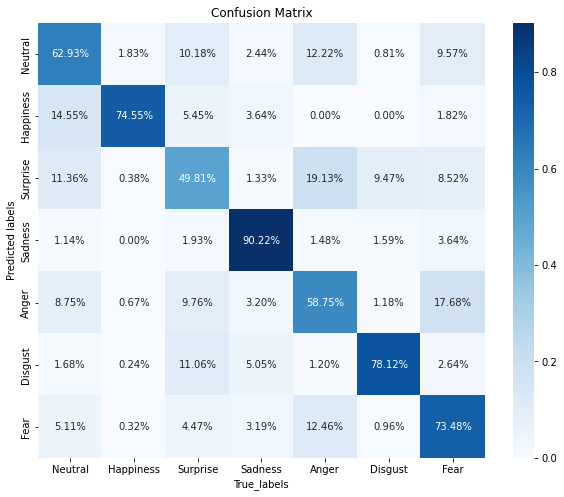

In [ ]:
get_models.Confusion_Matrix(model , images, test_labels ,  emotionferp, mode = True)

#plot wrong imgae

In [ ]:
Y_pred = model.predict(images)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

wrong_images, T_labels, F_labels = [], [] ,[]
for i, test_image in enumerate(images):
    if y_pred[i] == y_true[i]:
      wrong_images.append(test_image)
      T_labels.append(y_true[i])
      F_labels.append(y_pred[i])
    else:
      pass

In [ ]:
len(T_labels)

2540

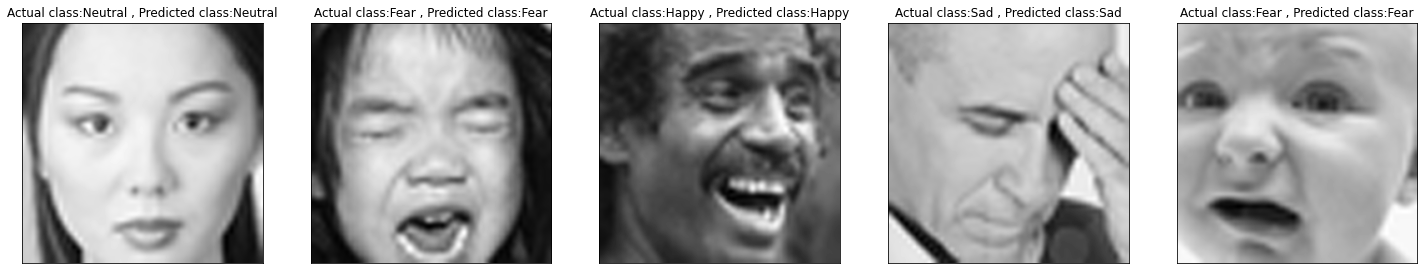

In [ ]:
emotionfer = ["Angry" , "Disgust", "Fear", "Happy", "Sad", "Surprise" , "Neutral"  ]

plt.figure(figsize=(25,20))
for i in range(5):
    idx = np.random.randint(0, len(wrong_images) - 1)
    plt.subplot(1, 5, i+1)
    img = wrong_images[idx]
    plt.imshow(img[:,:,0], cmap='gray')

    True_labels =  emotionfer[T_labels[idx]]
    False_labels = emotionfer[F_labels[idx]]

    plt.title('Actual class:{} , Predicted class:{}'.format(True_labels, False_labels), size=12, color="black") 
    plt.xticks([])
    plt.yticks([])

# attention

In [ ]:
# Create input shape
img_size_target = 48
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
# in_lay = Input((128,128,3))
model = VGG16(input_shape = None, input_tensor = img_conc ,
                              include_top = False, weights = 'imagenet')
inputs = model.input 

X_add = []


# for i in range(5):
net1 = model.layers[4].output
net2 = model.layers[7].output
net3 = model.layers[11].output
net4 = model.layers[16].output
net5 = model.layers[-1].output

att1 = attention_module.attach_attention_module(net1, attention_module = "cbam_block")
att2 = attention_module.attach_attention_module(net2, attention_module = "cbam_block")
att3 = attention_module.attach_attention_module(net3, attention_module = "cbam_block")
att4 = attention_module.attach_attention_module(net4, attention_module = "cbam_block")
att5 = attention_module.attach_attention_module(net5, attention_module = "cbam_block")

x1 = keras.layers.add([net1, att1])
x2 = Activation('relu')(x1)
x2 = keras.layers.add([net2, att2])(x2)
x3 = Activation('relu')(x2)
x3 = keras.layers.add([net3, att3])(x3)
x4 = Activation('relu')(x3)
x5 = keras.layers.add([net4, att4])(4)
x = keras.layers.add([net5, att5])(x5)




x = Activation('relu')(x)
# x = layers.Flatten()(x)
# fcHead = layers.Dense(1024,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                       bias_regularizer=regularizers.L2(1e-4),
#                       activity_regularizer=regularizers.L2(1e-5))(x)
# fcHead = layers.Activation('relu')(fcHead)
# fcHead = layers.Dropout(0.2)(fcHead)

# fcHead = layers.Dense(256,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                       bias_regularizer=regularizers.L2(1e-4),
#                       activity_regularizer=regularizers.L2(1e-5))(fcHead)
# fcHead = layers.Activation('relu')(fcHead)
# fcHead = layers.Dropout(0.2)(fcHead)

# fcHead = layers.Dense(128,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                       bias_regularizer=regularizers.L2(1e-4),
#                       activity_regularizer=regularizers.L2(1e-5))(fcHead)
# fcHead = layers.Activation('relu')(fcHead)
# fcHead = layers.Dropout(0.2)(fcHead)

# fcHead = layers.Dense(7, activation='softmax')(fcHead)
# model = keras.Model(inputs=inputs, outputs=fcHead)

TypeError: ignored

In [ ]:
att

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'multiply_1')>

In [ ]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 48, 48, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 48, 48, 64)   1792        ['concatenate[0][0]']            
                                                                                              

In [ ]:
4 7 11 15 19

## Test2

In [ ]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt

import random

# Declare an augmentation pipeline
transforms = A.Compose([
            A.Rotate(limit=40),
            A.RandomBrightness(limit=0.1),
            # JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.HorizontalFlip(),
        ])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("/content/cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transforms(image=image)
transformed_image = transformed["image"]

error: ignored

In [ ]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
image = cv2.imread("/content/cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [ ]:

random.seed(0)
# Augment an image
transformed = transforms(image=image)
transformed_image = transformed["image"]
visualize(transformed_image)

In [ ]:
import tensorflow as tf

def train_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    # aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img


In [ ]:
image = train_fn(image)

In [ ]:
image

## Test 3

## Test 4

In [ ]:
# data augumentation keras
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing.image import img_to_array
def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen
    

In [ ]:
images = []
data = cv2.imread("/content/cat.jpg")
array = cv2.resize(data, (255, 255))
image = img_to_array(array)
image = image.resize(255, 255, 3)
image = np.expand_dims(array, axis = 0)


In [ ]:
image.shape

In [ ]:
visualize(image[0])

In [ ]:
datagen = data_augmentation(image)

In [ ]:
x = datagen.flow(image)

In [ ]:
augmented_data = []
num_augmented = 0
for X_batch in datagen.flow(image, batch_size= 1):
    augmented_data.append(X_batch.astype("float64"))
    num_augmented += 1
    if num_augmented == 10:
        break
augmented_data = np.concatenate(augmented_data)

In [ ]:
for i in range(9):
  visualize(np.array(augmented_data[i]))

In [ ]:
augmented_data.shape